In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from random import randint
import time
import utils
import numpy as np
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import cv2
import random

In [3]:
def process_dataset(dataset):
    X = []
    y = []
    for i, (k, v) in enumerate(dataset.items()):
        X.append(v)
        y.append([i] * v.shape[0])
    X = np.concatenate(X)
    y = np.concatenate(y)
    X = torch.from_numpy(X).type(torch.float32)
    y = torch.from_numpy(y).type(torch.int64)
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    return dataset, dataloader

In [201]:
dataset_train = np.load('dataset/dataset_train.npy', allow_pickle=True)[()]
dataset_test = np.load('dataset/dataset_test.npy', allow_pickle=True)[()]

In [202]:
train_dataset, train_dataloader = process_dataset(dataset_train['cifar'])
test_dataset, test_dataloader = process_dataset(dataset_test['cifar'])

In [363]:
device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device.")

class MLP(nn.Module):
    def __init__(self, x_dim, h_dim, y_dim):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(x_dim, 1024, bias=False)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512, bias=False)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256, bias=False)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128, bias=False)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 64, bias=False)
        self.bn5 = nn.BatchNorm1d(64)
        self.fc6 = nn.Linear(64, 32, bias=False)
        self.bn6 = nn.BatchNorm1d(32)
        self.fc7 = nn.Linear(32, y_dim, bias=False)
        # self.relu = nn.LeakyReLU(negative_slope=0.2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.flatten(x)
        # x = self.bn1(self.relu(self.fc1(x)))
        # x = self.bn2(self.relu(self.fc2(x)))
        # x = self.bn3(self.relu(self.fc3(x)))
        # x = self.bn4(self.relu(self.fc4(x)))
        # x = self.bn5(self.relu(self.fc5(x)))
        # x = self.bn6(self.relu(self.fc6(x)))
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.fc7(x)
        return x

model = MLP(3072, 128, 10).to(device)
print(model)
utils.display_num_param(model)

Using cpu device.
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=1024, bias=False)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=False)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=256, bias=False)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=128, bias=False)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=128, out_features=64, bias=False)
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=64, out_features=32, bias=False)
  (bn6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc7): Linea

In [4]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            losses.append(loss)
    return losses

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct * 100

In [9]:
epochs = 20
training_losses = []
test_accuracy = []
for t in range(epochs):
    print(f"Epoch {t+1} - ", end="")
    train_losses = train(train_dataloader, model, loss_fn, optimizer)
    test_acc = test(test_dataloader, model, loss_fn)
    training_losses += train_losses
    test_accuracy.append(test_acc)

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 30.9%, Avg loss: 1.989964 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 35.0%, Avg loss: 1.861700 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 36.6%, Avg loss: 1.781065 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 37.0%, Avg loss: 1.789023 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 38.6%, Avg loss: 1.801456 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 36.8%, Avg loss: 1.824191 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 39.9%, Avg loss: 1.734600 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 38.9%, Avg loss: 1.839155 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 41.1%, Avg loss: 1.744527 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 41.3%, Avg loss: 1.770988 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 40.2%, Avg los

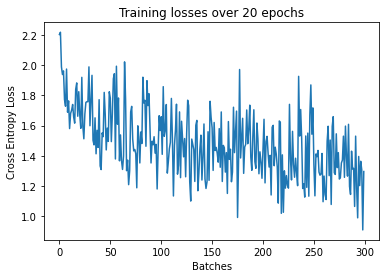

In [12]:
plt.title("Training losses over 20 epochs")
plt.xlabel("Batches")
plt.ylabel("Cross Entropy Loss")
plt.plot(training_losses)
plt.show()

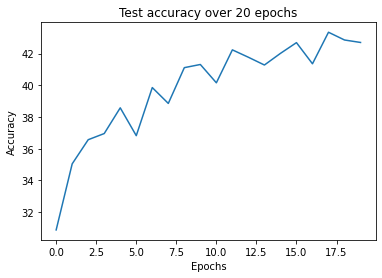

In [13]:
plt.title("Test accuracy over 20 epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(test_accuracy)
plt.show()

In [344]:
def combined_dataset(dataset, size):
    combined = {}
    for name, data in dataset.items():
        if name in dataset:
            for clas, d in data.items():
                resized = []
                for img in d:
                    resized.append(cv2.resize(img, (size,size), interpolation=cv2.INTER_AREA))
                if clas not in combined:
                    combined[clas] = [resized]
                else:
                    combined[clas].append(resized)
    for clas, data in combined.items():
        combined[clas] = np.concatenate(data, axis=0)
    return combined

In [352]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, size, DOODLES, REAL):
        super(ImageDataset, self).__init__()
        CLASSES = ["airplane", "car", "bird", "cat", "dog", "frog", "horse", "ship", "truck"]
        dataset = np.load(data_dir, allow_pickle=True)[()]
        
        doodle_dataset = {name: data for name, data in dataset.items() if name in DOODLES}
        real_dataset = {name: data for name, data in dataset.items() if name in REAL}
        doodles = combined_dataset(doodle_dataset, size)
        real = combined_dataset(real_dataset, size)
        
        class_to_idx = {k: i for i, k in enumerate(CLASSES)}
            
        self.doodle_data, self.doodle_label = self._return_x_y_pairs(doodles, class_to_idx)
        self.real_data, self.real_label = self._return_x_y_pairs(real, class_to_idx)

        # data preprocessing
        self.doodle_preprocess = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize((self.doodle_data/255).mean(), (self.doodle_data/255).std())
        ])
        self.real_preprocess = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize((self.real_data/255).mean(axis=(0,1,2,3)), (self.real_data/255).std(axis=(0,1,2,3))),
            # transforms.Normalize(self.real_data.mean(), self.real_data.std()),
        ])

        print(f'Dataset. Doodle data size {len(self.doodle_data)}, real data size {len(self.real_data)}, '
              f'ratio {len(self.doodle_data)/len(self.real_data):.3f}, {self.real_data.mean(), self.real_data.std()}')

    def _return_x_y_pairs(self, dataset, class_to_idx):
        xs, ys = [], []
        for clas, data in dataset.items():
            labels = [class_to_idx[clas]] * len(data)
            xs.append(data)
            ys.extend(labels)
        return np.concatenate(xs, axis=0), np.array(ys)

    def __getitem__(self, idx):
        # naive sampling scheme - sample with replacement
        doodle_idx, real_idx = random.randint(0, len(self.doodle_data) - 1), random.randint(0, len(self.real_data) - 1)
        doodle_data = self.doodle_preprocess(self.doodle_data[doodle_idx])
        real_data = self.real_preprocess(self.real_data[real_idx])
        return doodle_data, self.doodle_label[doodle_idx], real_data, self.real_label[real_idx]

    def __len__(self):
        return max(len(self.doodle_data), len(self.real_data))     # could be arbitrary number

In [368]:
DOODLES = ['sketchy_doodle', 'tuberlin', 'google_doodles']
REAL = ['sketchy_real', 'google_real', 'cifar']
train_dataset = ImageDataset("dataset/dataset_train.npy", 32, DOODLES, REAL)
test_dataset = ImageDataset("dataset/dataset_test.npy", 32, DOODLES, REAL)

Dataset. Doodle data size 7022, real data size 46364, ratio 0.151, (121.70084711243278, 65.10291249861656)
Dataset. Doodle data size 1764, real data size 9341, ratio 0.189, (123.28941366940772, 64.57142732393959)


In [369]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [374]:
model = MLP(1024, 128, 10).to(device)
# model = MLP(3072, 128, 10).to(device)
print(model)
utils.display_num_param(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1024, out_features=1024, bias=False)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=False)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=256, bias=False)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=128, bias=False)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=128, out_features=64, bias=False)
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=64, out_features=32, bias=False)
  (bn6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc7): Linear(in_features=32, 

In [375]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [376]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y, _, _) in enumerate(dataloader):
        X, y = X.to(device), y.to(device).type(torch.LongTensor)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            correct = (pred.argmax(1) == y).type(torch.float).sum().item()
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}], Acc: {(100*correct/len(X)):>0.1f}%")
            losses.append(loss)
    return losses

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y, _, _ in dataloader:
            X, y = X.to(device), y.to(device).type(torch.LongTensor)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct * 100

In [377]:
epochs = 20
training_losses = []
test_accuracy = []
for t in range(epochs):
    print(f"Epoch {t+1} - ", end="")
    train_losses = train(train_dataloader, model, loss_fn, optimizer)
    test_acc = test(test_dataloader, model, loss_fn)
    training_losses += train_losses
    test_accuracy.append(test_acc)

Epoch 1 - Loss: 2.302975  [    0/46364], Acc: 9.4%
Loss: 2.073838  [ 3200/46364], Acc: 28.1%
Loss: 1.884107  [ 6400/46364], Acc: 28.1%
Loss: 2.012756  [ 9600/46364], Acc: 15.6%
Loss: 1.795143  [12800/46364], Acc: 15.6%
Loss: 1.671877  [16000/46364], Acc: 43.8%
Loss: 1.920967  [19200/46364], Acc: 25.0%
Loss: 1.634478  [22400/46364], Acc: 31.2%
Loss: 1.579832  [25600/46364], Acc: 37.5%
Loss: 1.860176  [28800/46364], Acc: 28.1%
Loss: 1.348436  [32000/46364], Acc: 40.6%
Loss: 1.363034  [35200/46364], Acc: 43.8%
Loss: 1.179522  [38400/46364], Acc: 46.9%
Loss: 1.415623  [41600/46364], Acc: 40.6%
Loss: 1.252884  [44800/46364], Acc: 59.4%
Test Error: 
 Accuracy: 33.6%, Avg loss: 1.979432 

Epoch 2 - Loss: 1.186353  [    0/46364], Acc: 59.4%
Loss: 1.301276  [ 3200/46364], Acc: 59.4%
Loss: 1.161498  [ 6400/46364], Acc: 62.5%
Loss: 1.242755  [ 9600/46364], Acc: 43.8%
Loss: 1.174426  [12800/46364], Acc: 59.4%
Loss: 1.273609  [16000/46364], Acc: 40.6%
Loss: 1.028116  [19200/46364], Acc: 59.4%
Loss:

KeyboardInterrupt: 